In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

np.random.seed(114514)
xp.random.seed(114514)

has cupy


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has BBHx waveform


## Load data 

In [2]:
# the path of TDC data 
h5filename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_PhenomT_TDIXYZ_clean.h5"
with h5py.File(h5filename, "r") as h5file: 
    read_dict = read_dict_from_h5(h5file["/"])
read_dict.keys()

dict_keys(['XYZ', 'time'])

In [3]:
# the path of parameters 
h5paramfilename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_PhenomT_parameters.h5"
with h5py.File(h5paramfilename, "r") as h5file: 
    fiducial_parameters = read_dict_from_h5(h5file["/"])
fiducial_parameters

{'chirp_mass': array([1137881.8613132 , 1629545.50537553, 1884018.21778241,
        2941508.89437516,  741295.84197065,  849484.59118879,
         145796.12766449, 1461988.88933135, 3993333.22030406,
         644903.72899683,  398624.58790981,  566378.98996148,
        1569753.4559717 , 2411591.7552034 ,  129965.02729464,
        1818107.38417073,  677189.57592846, 2903525.67351682,
        1914913.30570649,  796930.55142179,  439062.57858882,
        1584273.62459611, 1512587.7631214 , 1365823.00229545,
          47672.6099889 , 2089369.60801333, 1277815.71734841,
        1195671.13831125, 3007474.79536178, 1771201.02668473,
        1111395.65885511, 1485109.8546206 ,  990790.37278852,
        1665812.41230761, 2800089.14971012,  933600.28864936,
        3208343.42287825,  872173.96055505,  791669.30821356,
        1128326.17598778, 1631008.41781651, 2313986.66440118,
        1373236.35066362, 1689336.95309265, 1214552.09775294,
        2301219.05867977,  789795.25045201, 1390273.5524

## Combine AET and slice data

In [4]:
dt = read_dict["time"][1] - read_dict["time"][0]

A2_td, E2_td, T2_td = AETfromXYZ(read_dict["XYZ"]["X2"], read_dict["XYZ"]["Y2"], read_dict["XYZ"]["Z2"])

In [5]:
# fff, xfff = PSD_window(A2_td, 1./dt, nbin=50, window_type="kaiser", window_args_dict=dict(beta=28))
# plt.loglog(fff, np.sqrt(xfff))

# fff, xfff = PSD_window(E2_td, 1./dt, nbin=50, window_type="kaiser", window_args_dict=dict(beta=28))
# plt.loglog(fff, np.sqrt(xfff))

# fff, xfff = PSD_window(T2_td, 1./dt, nbin=50, window_type="kaiser", window_args_dict=dict(beta=28))
# plt.loglog(fff, np.sqrt(xfff))

# PSDfunc = TDIPSDs()
# plt.loglog(fff, np.sqrt(PSDfunc.PSD_A2(fff)), linestyle="--")
# plt.loglog(fff, np.sqrt(PSDfunc.PSD_T2(fff)), linestyle="--") # doesn't match since this is based on equal-arm approximation

# plt.xlabel("Frequency (Hz)")
# plt.ylabel("ASD")
# plt.xlim(1e-5, 0.1)
# plt.ylim(1e-25,)
# plt.grid(linestyle=":")

In [6]:
start_time = 345.5 * DAY 
end_time = 345.7 * DAY 

slice_idx = np.where((read_dict["time"] >= start_time)&(read_dict["time"] <= end_time))[0]
A2_td, E2_td, T2_td = A2_td[slice_idx], E2_td[slice_idx], T2_td[slice_idx]

AET_dict = {
    "A2": A2_td, 
    "E2": E2_td,
    "T2": T2_td,
}

channel_names = list(AET_dict.keys())


A2_td.shape, dt

((3457,), 5.0)

Text(0, 0.5, 'TDI')

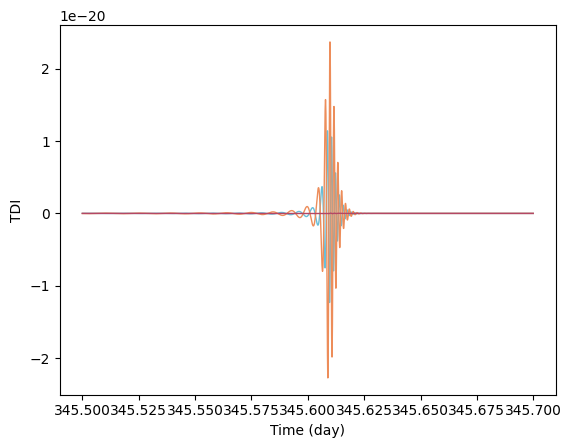

In [7]:
for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, RED]):
    plt.plot(read_dict["time"][slice_idx]/DAY, AET_dict[nch], label=nch, linewidth=1, color=cch)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
# plt.xlim(end_time/DAY - 0.2, end_time/DAY)

## Load parameters for comparison 

In [8]:
mbhb_idx = np.where((fiducial_parameters["coalescence_time"] >= start_time/DAY)&(fiducial_parameters["coalescence_time"] <= end_time/DAY))[0]
N_mbhb = len(mbhb_idx)
for k, v in fiducial_parameters.items():
    fiducial_parameters[k] = v[mbhb_idx]
N_mbhb, fiducial_parameters

(1,
 {'chirp_mass': array([1277815.71734841]),
  'coalescence_phase': array([5.43560597]),
  'coalescence_time': array([345.60980197]),
  'inclination': array([1.73738189]),
  'latitude': array([1.04001318]),
  'longitude': array([0.73000579]),
  'luminosity_distance': array([69694.79307183]),
  'mass_ratio': array([0.98078291]),
  'psi': array([0.57565928]),
  'spin_1z': array([0.922202]),
  'spin_2z': array([-0.225115])})

## Fourier transform 

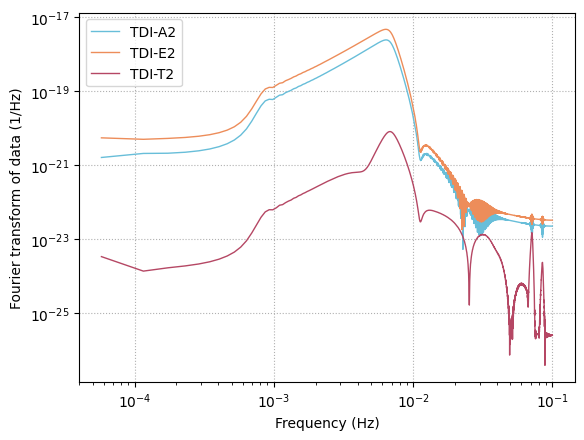

In [9]:
data_channels = [] 
for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, RED]):
    ff, xf = FFT_window(AET_dict[nch], 1./dt, window_type="tukey", window_args_dict=dict(alpha=0))
    plt.loglog(ff, np.abs(xf), linewidth=1, color=cch, label="TDI-"+nch)
    data_channels.append(xf * np.exp(-TWOPI * 1.j * ff * start_time)) # notice the time shift factor 
data_frequency = ff 
data_channels = np.array(data_channels)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform of data (1/Hz)")
plt.legend(loc="upper left")
plt.grid(linestyle=":")

Limit the frequency band to gain speed and avoid singularity

In [10]:
mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 40):
    mask_idx = np.where(np.abs(data_frequency - i * 0.025) < 3e-4 * i)[0]
    mask[mask_idx] = False 
mask_idx = np.where(data_frequency>0.01)[0]
mask[mask_idx] = False 
mask_idx = np.where(data_frequency<5e-4)[0]
mask[mask_idx] = False 

data_frequency = xp.array(data_frequency[mask])
delta_f = data_frequency[1] - data_frequency[0]
Tobs = 1. / delta_f
data_channels = xp.array(data_channels[:, mask])

data_frequency.shape, data_channels.shape 

((164,), (3, 164))

## Prepare models 

### waveform and response 

In [11]:
mode = "primary" # use primary (2,2) mode for the PhenomD waveform 
use_gpu = True 

# the path of Taiji orbit 
ORBIT_DIR = "/home/ps/workspace/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB"
orbit = Orbit(OrbitDir=ORBIT_DIR)

# initialize  waveform generator 
WFG = BBHxWaveformGenerator(mode=mode, use_gpu=use_gpu)

# initialize response generator 
FDTDI = BBHxFDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)

# response settings 
response_kwargs = dict(
    modes=[(2,2),], 
    tmin=start_time/DAY,
    tmax=end_time/DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=False,
)

response_kwargs

{'modes': [(2, 2)],
 'tmin': 345.5,
 'tmax': 345.7,
 'tc_at_constellation': False,
 'TDIGeneration': '2nd',
 'optimal_combination': True,
 'output_by_mode': False,
 'interpolation': False}

## Model noise 
Simplifications:
- AE channels are only approximately independent. 
- The noise level of T channel varies significantly with time, thus we do not use T channel in subsequent analysis. 
- During realistic search we usually do not priorly know the PSD of noise 

In [12]:
# noise PSD model 
PSDfunc = TDIPSDs()

# use the median time to calculate armlengths. The PSD of T channel is sensitive to armlength variation, while those of AE are approximately stationary for most frequencies. 
arm_time = (start_time + end_time) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit.LTTfunctions()[key](arm_time)
print("arm lengths:", arms)

# T will not be used 
PSD_channels = xp.array([
    PSDfunc.PSD_A2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_E2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_T2_unequal(data_frequency.get(), arms)
])

# covariance matrix, this is also an approximate since the channels should be correlated under the unequal-arm regime
CovMat = xp.array([
    [PSD_channels[0], xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), PSD_channels[1], xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = xp.linalg.inv(xp.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)

PSD_channels.shape, InvCovMat.shape 

arm lengths: {'12': array(9.97399181), '13': array(9.92342647), '23': array(9.91830904), '21': array(9.97394839), '31': array(9.92216786), '32': array(9.91707669)}


((3, 164), (164, 3, 3))

## Test model with the true parameters 

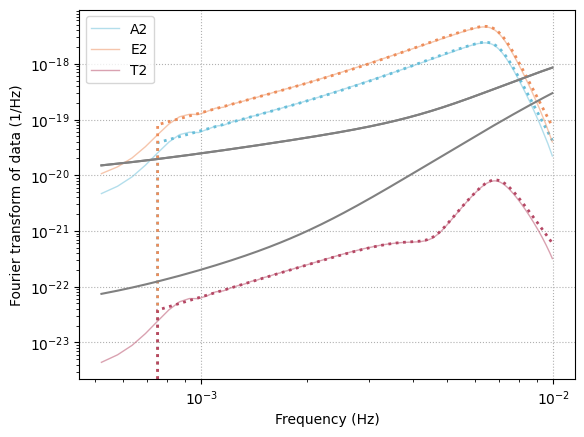

In [13]:
# calculate template 
model_channels = FDTDI.Response(parameters=fiducial_parameters, freqs=data_frequency, **response_kwargs)

for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, RED]):
    plt.loglog(data_frequency.get(), np.abs(data_channels[ich].get()), label=nch, linewidth=1, color=cch, alpha=0.5)
    plt.loglog(data_frequency.get(), np.abs(model_channels[ich].get()), linewidth=2, linestyle=":", color=cch)
    plt.loglog(data_frequency.get(), np.sqrt((PSD_channels[ich] * Tobs / 2.).get()), color="grey")

plt.legend(loc="upper left")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform of data (1/Hz)")
plt.grid(linestyle=":")

## Use A, E channels only 
set $C^{-1}_{T_2 T_2} \equiv 0$ to eliminate the contribution of $T_2$

In [14]:
InvCovMat[:, 2, 2] *= 0. 

## Likelihood

In [15]:
Like = Likelihood(
    response_generator=FDTDI, 
    frequency=data_frequency, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs, 
    use_gpu=use_gpu,
)

number of freuqncies: 164
min and max frequencies: 0.0005206826728377206 0.009950824414231993
response kwargs: {'modes': [(2, 2)], 'tmin': 345.5, 'tmax': 345.7, 'tc_at_constellation': False, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': False}


## Run MCMC Sampling 

the aim is to compare the posteriors of full and heterodyned likelihoods, so we choose ideal priors and starting points. 

In [16]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [17]:
labels = [r"${\rm lg}\mathcal{M}_{c,z}$", r"$q$", r"$\chi_{z,1}$", r"$\chi_{z,2}$", r"$t_c$", r"$\varphi_c$", r"${\rm lg} D_L$", r"$\cos \iota$", r"$\lambda$", r"$\sin \beta$", r"$\psi$"]

truths = np.array(ParamDict2ParamArr(fiducial_parameters))

truths = truths[:, 0]

truths

array([ 6.10646823e+00,  9.80782914e-01,  9.22202000e-01, -2.25115000e-01,
        3.45609802e+02,  5.43560597e+00,  4.84320033e+00, -1.65816150e-01,
        7.30005791e-01,  8.62410900e-01,  5.75659285e-01])

In [18]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 400 # number of random walkers, limited by the vRAM of my 4080S, use fewer (e.g. 100) to speed up and more (e.g. 400) to get more smooth posterior 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # mcmc move 

stop = None 

# set priors 
lim_lgMc = [truths[0] - 0.1, truths[0] + 0.1] # we have demonstrated that this is practical 
lim_q = [0.1, 0.99]
lim_chiz1 = [-0.99, 0.99]
lim_chiz2 = [-0.99, 0.99]
lim_tc = [truths[4] - 2e-2, truths[4] + 2e-2] # we have demonstrated that this is practical 
lim_phic = [0, TWOPI]
lim_lgD = [truths[6] - 0.5, truths[6] + 0.5] # we have demonstrated that this is practical 
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
start_lims = lims 
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 6.00646823e+00,  6.20646823e+00],
        [ 1.00000000e-01,  9.90000000e-01],
        [-9.90000000e-01,  9.90000000e-01],
        [-9.90000000e-01,  9.90000000e-01],
        [ 3.45589802e+02,  3.45629802e+02],
        [ 0.00000000e+00,  6.28318531e+00],
        [ 4.34320033e+00,  5.34320033e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  6.28318531e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  3.14159265e+00]]),
 array([[ 6.00646823e+00,  6.20646823e+00],
        [ 1.00000000e-01,  9.90000000e-01],
        [-9.90000000e-01,  9.90000000e-01],
        [-9.90000000e-01,  9.90000000e-01],
        [ 3.45589802e+02,  3.45629802e+02],
        [ 0.00000000e+00,  6.28318531e+00],
        [ 4.34320033e+00,  5.34320033e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  6.28318531e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  3.14159265e+00]]))

In [19]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    return Like.full_log_like_vectorized(np.transpose(params))

In [20]:

ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [21]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 400, 11)


 50%|█████     | 50254/100000 [54:46<52:18, 15.85it/s]  Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/taiji_data/lib/python3.9/site-packages/eryn/ensemble.py", line 1584, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_6979/3181406468.py", line 3, in eryn_like
    return Like.full_log_like_vectorized(np.transpose(params))
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Utils.py", line 163, in full_log_like_vectorized
    template = self.response_generator.Response(
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Response.py", line 1125, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Response.py", line 964, in TransferFunction
    zero_inds = self.xp.where(t <

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.10312301,  0.84356339,  0.26851708, ...,  2.70545128,
         0.11812241,  1.39815597],
       [ 6.10839546,  0.90668701,  0.30299057, ...,  2.85569584,
         0.13227358,  1.34219536],
       [ 6.10503555,  0.85480474,  0.43566137, ...,  2.52594839,
        -0.0313809 ,  2.17498657],
       ...,
       [ 6.09191357,  0.59130189, -0.14569795, ...,  1.96576778,
         0.63597571,  0.59190328],
       [ 6.12881748,  0.51920988, -0.38710762, ...,  2.33191905,
         0.90385959,  1.59235605],
       [ 6.10414532,  0.61030517, -0.12461708, ...,  0.97635357,
         0.51062635,  0.37349073]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# resume run after the run is stopped 
thin_by =100
burn = 0
nsteps = int(150000 / thin_by) # this should be far more than enough 

out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

 10%|▉         | 14847/150000 [1:31:37<13:49:29,  2.72it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/taiji_data/lib/python3.9/site-packages/eryn/ensemble.py", line 1584, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_19180/3181406468.py", line 3, in eryn_like
    return Like.full_log_like_vectorized(np.transpose(params))
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Utils.py", line 163, in full_log_like_vectorized
    template = self.response_generator.Response(
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Response.py", line 1093, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Response.py", line 964, in TransferFunction
    zero_inds = self.xp.where

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.20626085,  0.24693776, -0.75352962, ...,  3.65628199,
        -0.47021811,  2.30377899],
       [ 6.21066731,  0.25188584, -0.77814555, ...,  3.47924523,
        -0.13985204,  2.31508191],
       [ 6.20532317,  0.24560574, -0.74343857, ...,  2.96589012,
        -0.07484138,  1.99931441],
       ...,
       [ 6.17648962,  0.40198869, -0.19876693, ...,  5.13556116,
        -0.33803223,  2.07383815],
       [ 6.16569001,  0.68077178, -0.23544677, ...,  3.56415506,
        -0.79054112,  1.42579579],
       [ 6.13374472,  0.60136833,  0.14870255, ...,  5.84453773,
         0.04667485,  1.32919608]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

## Show moves 

<Figure size 640x480 with 0 Axes>

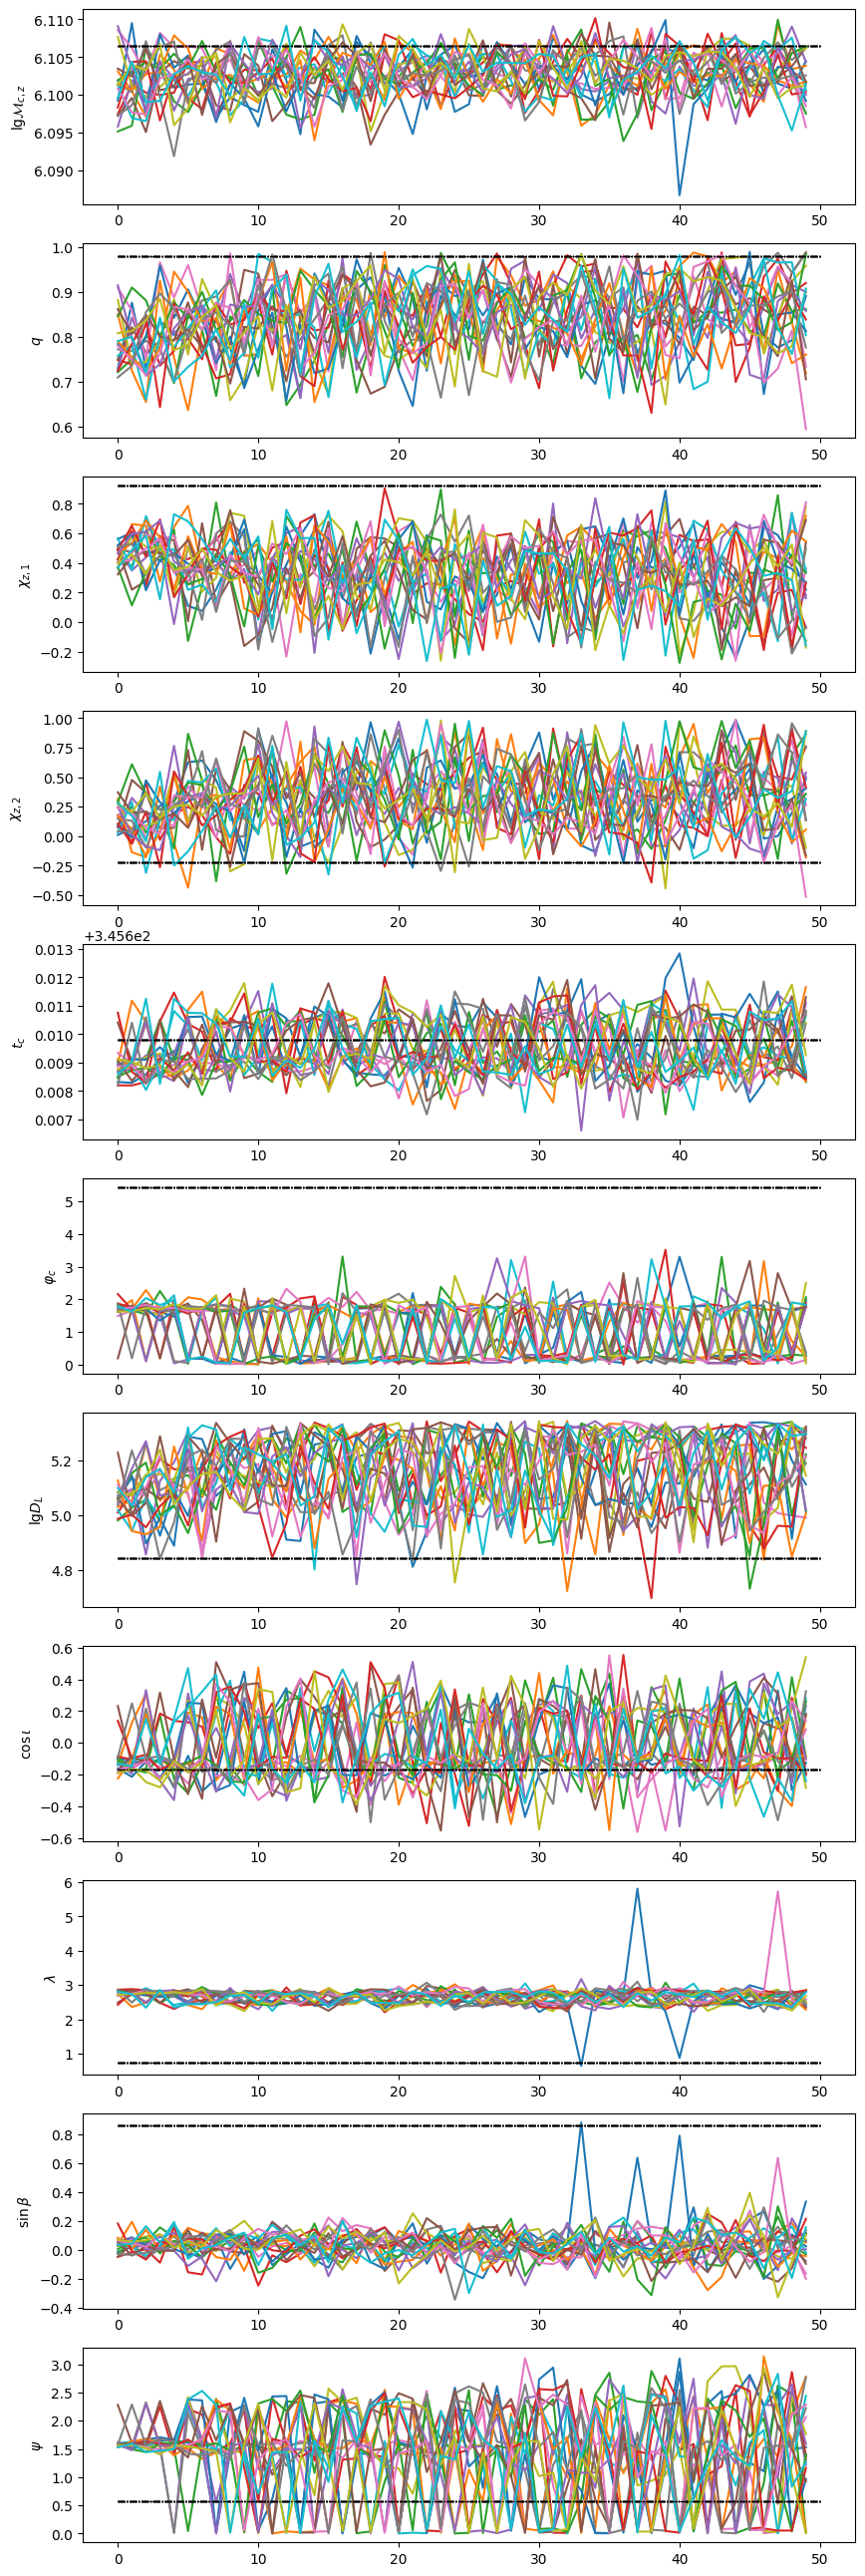

In [22]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])

## Corner plot
$t_c$ and $\varphi_c$ are not perfectly matched, the reason of which is explaned in Example 3.

sample shape: (12000, 11)


<Figure size 640x480 with 0 Axes>

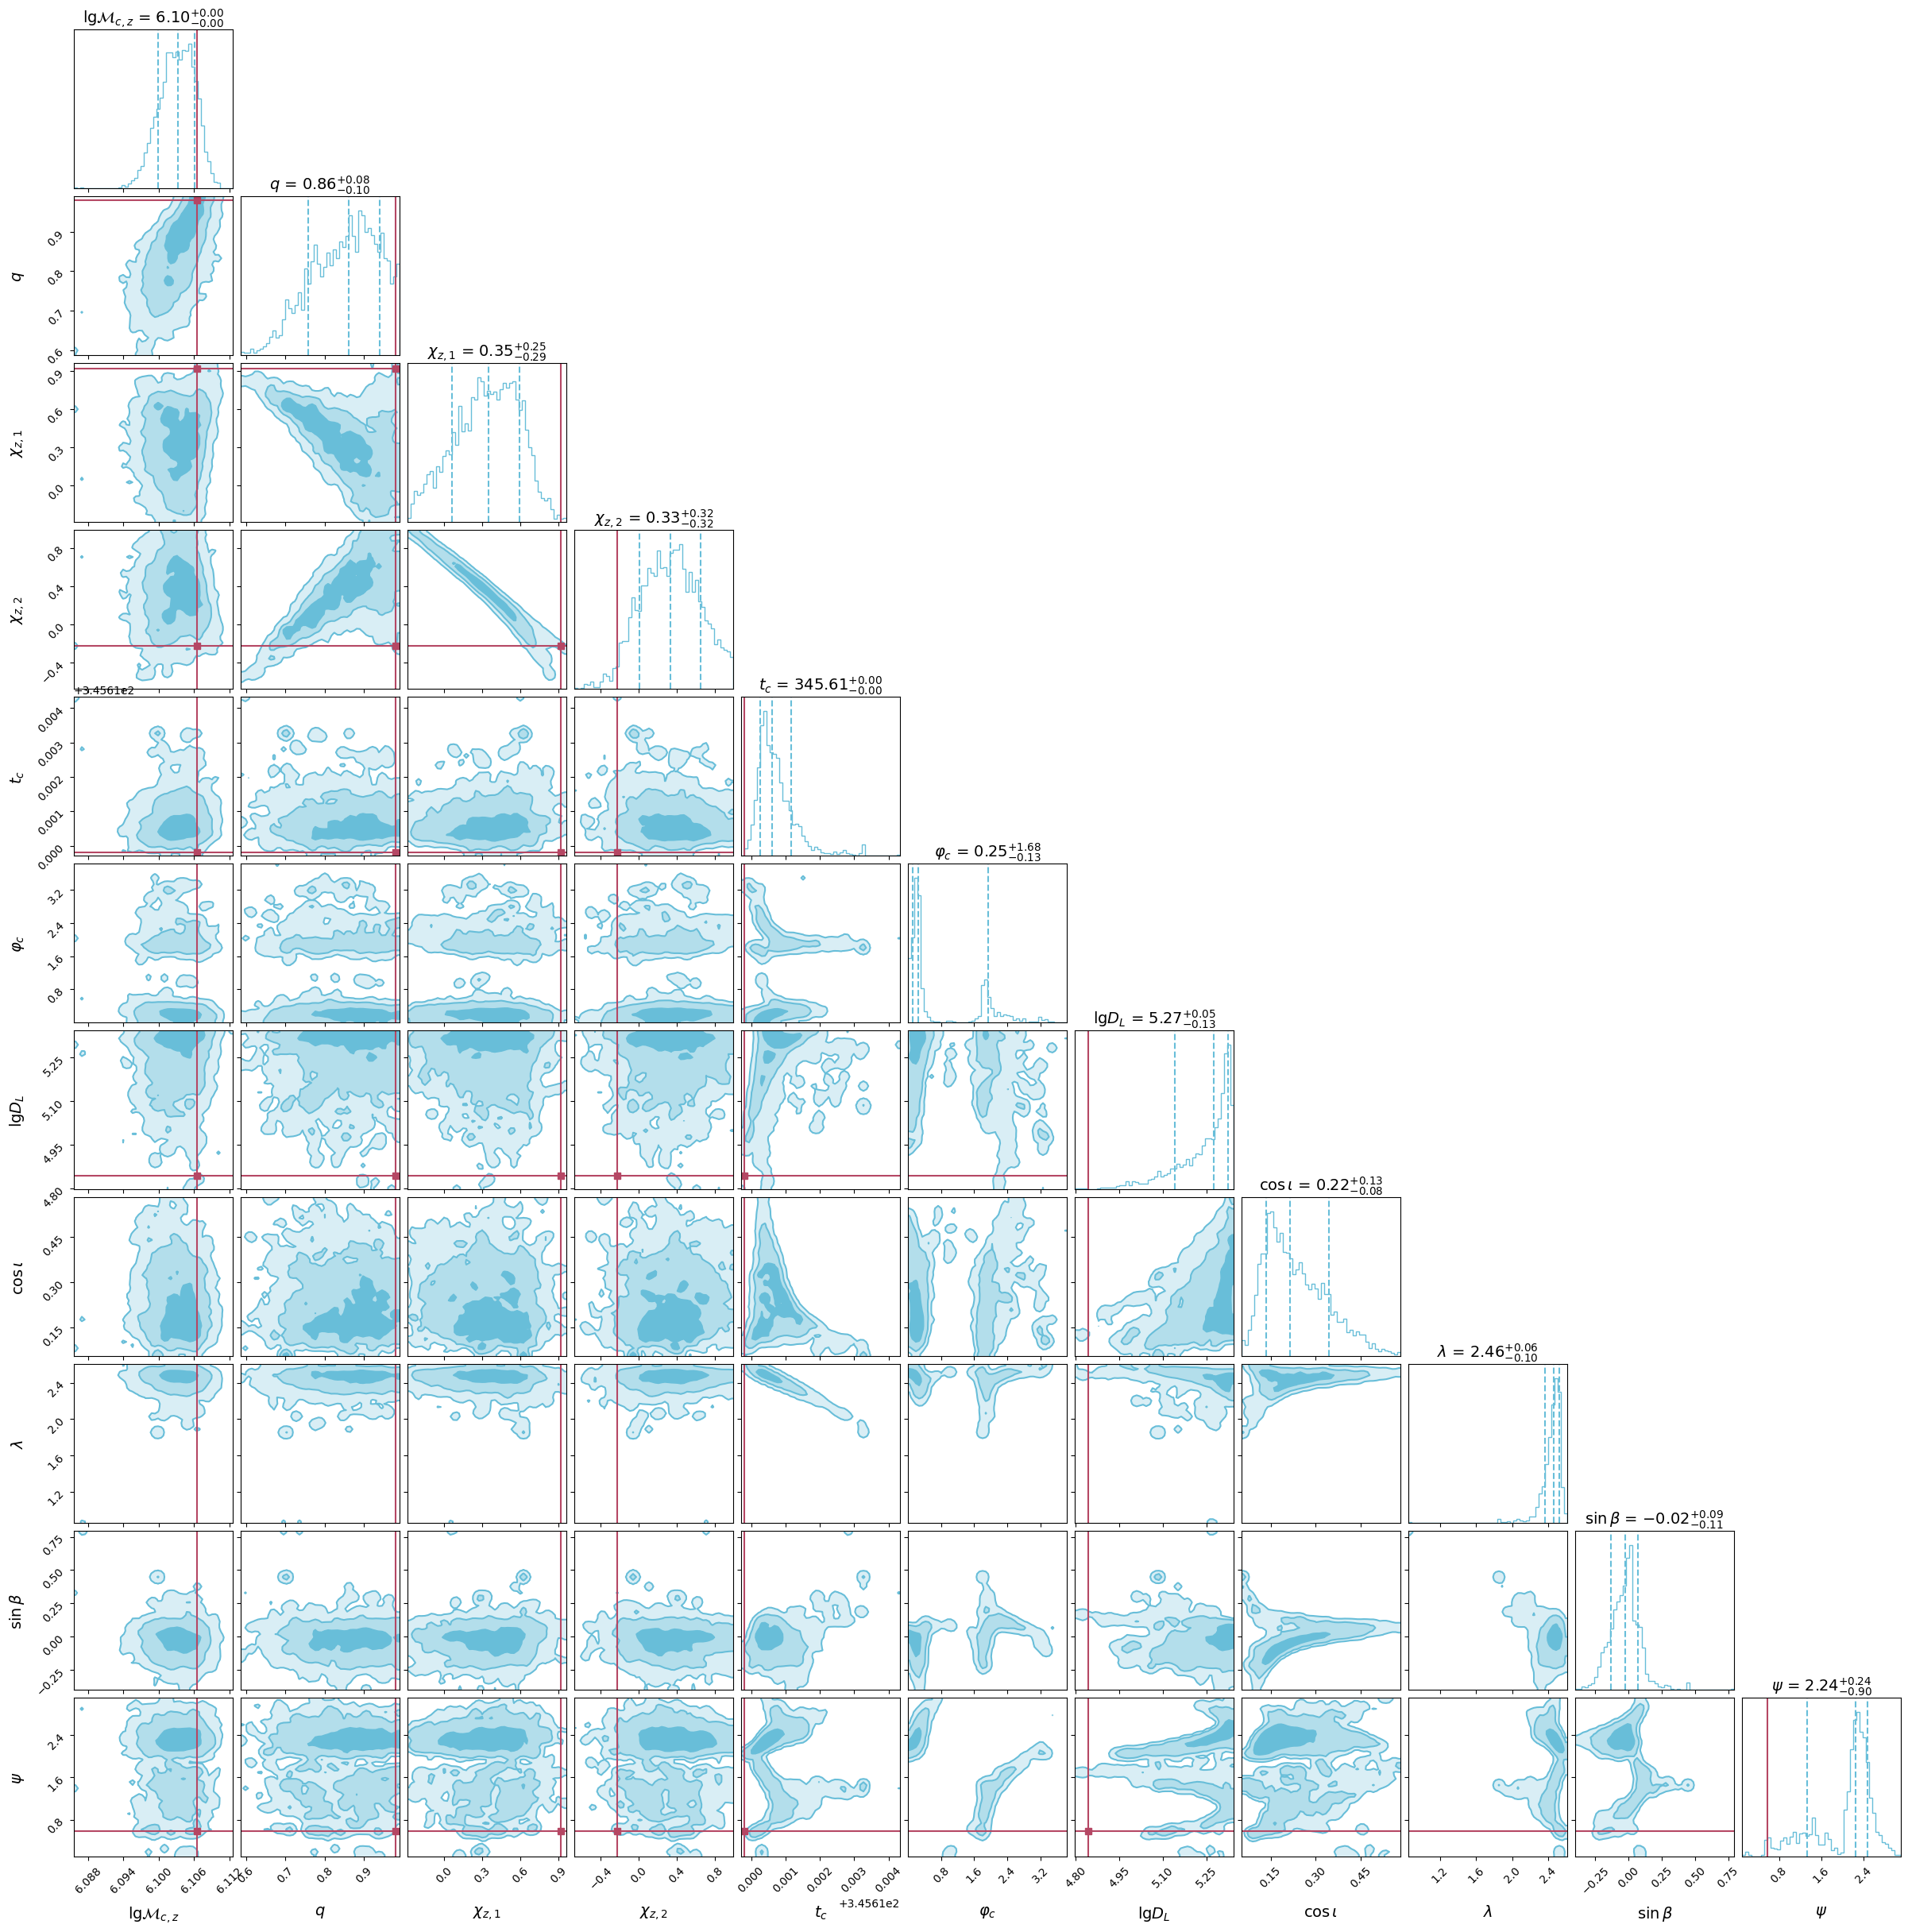

In [23]:
burnin=200
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

samp_idx = np.where(samp[:, 7]>0)[0]
samp = samp[samp_idx]

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("/home/ps/workspace/Triangle-BBH/Examples/Verification_corner.jpg")
# np.save("/home/ps/workspace/Triangle-BBH/Examples/chain_verification.npy", samp)